In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 1. Acquisition de la mire
## a. Récupération des coins de la 1ère mire

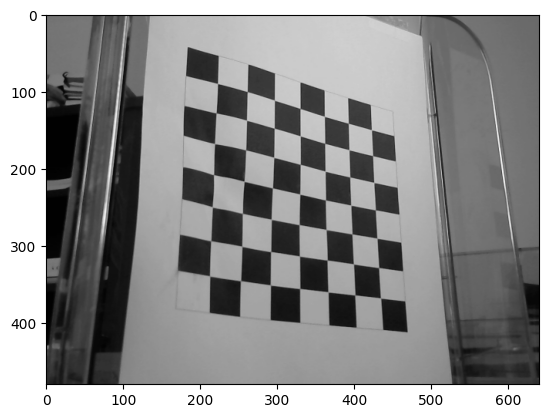

In [32]:
#Taille d'une case de la mire
c = 20  

#Récupération du chemin de l'image de la mire 1
img_path = "capture_mire_0.png"

#Lecture de l'image de la mire 1
img = cv2.imread(img_path)
plt.imshow(img)

#Détection des coins de la mire 1
res, corners = cv2.findChessboardCorners(img, (7,7))  

#coord_px : coordonnées pixels (49 premières valeurs correspondent à la mire 1)
coord_px = np.zeros((7*7*2,2), np.float32)
index_px = 0
for coord in corners:
    coord_px[index_px] = (coord[0][0], coord[0][1])
    index_px+=1

#coord_mm : coordonnées spatiales (49 premières valeurs correspondent à la mire 1)
coord_mm = np.zeros((7*7*2,3), np.float32)   
index = 0
for i in range(7):
    for j in range(7):
        coord_mm[index] = (c*j, c*i,0)
        index+=1


## b. Récupération des coins de la 2ème mire

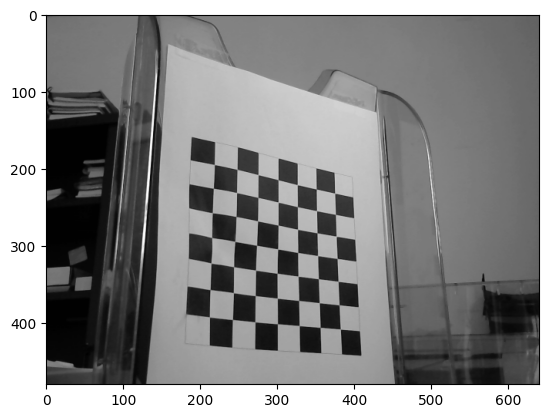

In [33]:
#Récupération du chemin de l'image de la mire 2
img_path_2 = "capture_mire_1.png"

#Lecture de l'image de la mire 2
img2 = cv2.imread(img_path_2)
plt.imshow(img2)

#Détection des coins de la mire 2
res2, corners2 = cv2.findChessboardCorners(img2, (7,7))  

#coord_px : coordonnées pixels (49 dernières valeurs correspondent à la mire 2)
for coord in corners2:
    coord_px[index_px] = (coord[0][0], coord[0][1])
    index_px+=1

#coord_mm : coordonnées spatiales (49 dernières valeurs correspondent à la mire 2)
for i in range(7):
    for j in range(7):
        coord_mm[index] = (c*j, c*i,120)
        index+=1

# 2. Calibrage de la caméra
## a. Construction de la matrice A et du vecteur U1 afin de résoudre le premier système linéaire

In [34]:
#Récuperation du centre de l'image avec d'avoir l'origine du repère Image
i1 = img.shape[1]/2
i2 = img.shape[0]/2

#Initialisation des matrices du système linéaire
A = []
U1 = []
N = len(coord_px)

#Construction des matrices A (Nx7) et U1 (Nx1)
for i in range(N):
    tmp = []
    ut1 = coord_px[i][0] - i1
    ut2 = coord_px[i][1] - i2
    x1 = coord_mm[i][0]
    x2 = coord_mm[i][1]
    x3 = coord_mm[i][2]
    tmp = [ut2*x1, ut2*x2, ut2*x3, ut2, -ut1*x1, -ut1*x2, -ut1*x3]
    A.append(tmp)
    U1.append(coord_px[i][0]-i1)

#Résolution de AL = U1
A = np.array(A)
AtA = np.dot(np.transpose(A),A)
L = np.dot(np.dot(np.linalg.pinv(AtA),np.transpose(A)),U1)

print("L = \n" + str(L))

L = 
[-1.19371838e-02 -1.04522388e-05  1.95537603e-03  6.44839825e-01
 -2.52041297e-03 -1.33307832e-02 -5.19888114e-03]


## b. Résolution analytique issue des paramètres de la matrice d'inconnues L

In [35]:
#Détermination des paramètres par résolution analytique
o2 = -1/(np.sqrt(L[4]**2 + L[5]**2+ L[6]**2))
beta = np.abs(o2)*np.sqrt(L[0]**2 + L[1]**2 + L[2]**2)
o1 = L[3]*o2/beta


#Paramètres de la matrice de rotation R
r11 = L[0]*o2/beta
r12 = L[1]*o2/beta
r13 = L[2]*o2/beta

r21 = L[4]*o2
r22 = L[5]*o2
r23 = L[6]*o2

r1 = [r11,  r12, r13]
r2 = [r21,  r22,  r23]

#Produit vectoriel des 2 premières lignes de la matrice de rotation donne la 3e ligne car matrice orthogonale
r31,r32,r33 = np.cross(r1, r2)   

#Déduction des angles de rotation à partir de la matrice de rotation R
phi = -np.arctan(r23/r33)
gamma = -np.arctan(r12/r11)
omega = np.arctan(r13/(-r23*np.sin(phi) + r33*np.cos(phi)))

print("\u03C6 : " + str(phi) + ", \u03B3 : " + str(gamma) + ", \u03C9 : " + str(omega))

φ : -0.37640812430599113, γ : -0.0008756031821894815, ω : -0.1645556702095641


## c. Construction de la matrice B et du vecteur R afin de résoudre le deuxième système linéaire

In [36]:
#Initialisation des matrices du système linéaire
B = []
R = []

#Construction des matrices B (Nx2) et R (Nx1)
for i in range(N):
    ut2 = coord_px[i][1] - i2
    x1 = coord_mm[i][0]
    x2 = coord_mm[i][1]
    x3 = coord_mm[i][2]
    tmp = [ut2, -(r21*x1 + r22*x2 + r23*x3 + o2)] 
    B.append(tmp)
    R.append([-ut2*(r31*x1 + r32*x2 + r33*x3)])

#Résolution de B * (o3*f2) = R
B = np.array(B)
BtB = np.dot(np.transpose(B),B)
o3, f2 = np.dot(np.dot(np.linalg.pinv(BtB),np.transpose(B)),R)

print("o₃ᶜ = " + str(o3) + ", f₂ = " + str(f2))

o₃ᶜ = [333.54985858], f₂ = [689.18862145]


In [37]:
#Focale de la caméra d'après les informations techniques du constructeur
f = 4 

#Détermination des facteurs d'échelle (mm/px)
s2 = f/f2[0]
s1 = s2/beta
print("Facteurs d'échelles (s1, s2): (" + str(s1) + ", " + str(s2) + ")")

f1 = f/s1

#Taille image = 640x480, on peut déduire la taille de la caméra à partir des facteurs d'échelles et de la taille de l'image
taille_capteur_x = s1*img.shape[1]
taille_capteur_y = s2*img.shape[0]
print("Taille du capteur : (" + str(taille_capteur_x) + ", " + str(taille_capteur_y) + ")")


Facteurs d'échelles (s1, s2): (0.006971152415212512, 0.005803926349786196)
Taille du capteur : (4.461537545736008, 2.785884647897374)


## d. Vérification du calibrage de la caméra avec l'image de la mire 1

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


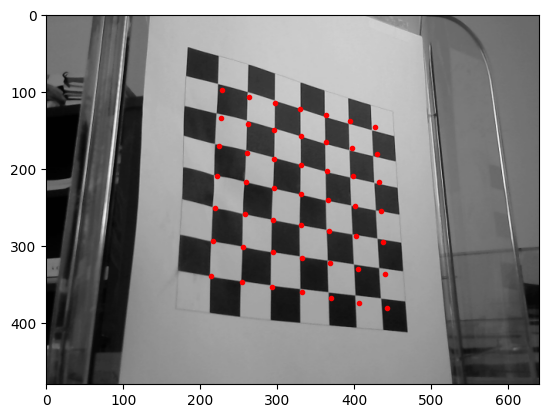

In [38]:
#Création des matrices extrinsèque et intrinsèque
Mext = [[r11, r12, r13, o1],[r21, r22, r23, o2],[r31, r32, r33, o3],[0,0,0,1]]  
Mint = [[f/s1, 0, i1, 0],[0,f/s2,i2,0],[0,0,1,0]] 

#Création de la matrice M (permettant de passer du repère Objet au repère Pixels)
M = np.dot(Mint, Mext)

#Projection des coordonnées Objets dans le repère Pixels de la première mire
U = []
plt.imshow(img)
for i in range(49):
    x1 = coord_mm[i][0]
    x2 = coord_mm[i][1]
    x3 = coord_mm[i][2]

    x3c = r31*x1+r32*x2+r33*x3+o3
    X = [x1,x2,x3, 1]
    U.append([np.dot(M, X)])

#Division des coordonnées u1 et u2 par alpha
Ux = [U[i][0][0]/U[i][0][2] for i in range(len(U))]
Uy = [U[i][0][1]/U[i][0][2] for i in range(len(U))]

#Affichage des points projetés dans le repère Pixels
plt.scatter(Ux,Uy, marker = ".", color = "r")

#Sauvegarde de l'image obtenue dans "img1.png"
plt.savefig("im1.png")
plt.show()


## e. Vérification du calibrage de la caméra avec l'image de la mire 2

[[573.7932212285538, 0, 320.0, 0], [0, 689.1886214488837, 240.0, 0], [0, 0, 1, 0]]


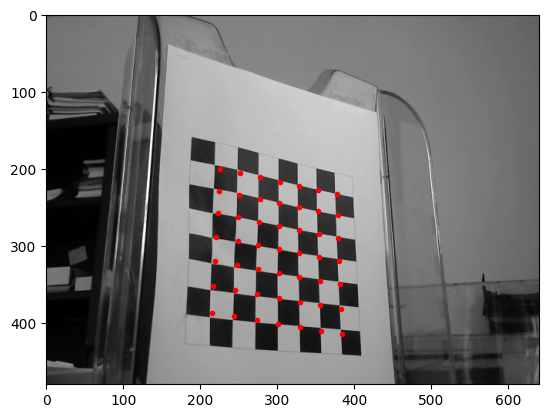

In [39]:
#Création des matrices extrinsèque et intrinsèque
Mext = [[r11, r12, r13, o1],[r21, r22, r23, o2],[r31, r32, r33, o3],[0,0,0,1]]  
Mint = [[f/s1, 0, i1, 0],[0,f/s2,i2,0],[0,0,1,0]] 

#Création de la matrice M (permettant de passer du repère Objet au repère Pixels)
M = np.dot(Mint, Mext)

#Projection des coordonnées Objets dans le repère Pixels de la première mire
U = []
plt.imshow(img2)
for i in range(49, 98):
    x1 = coord_mm[i][0]
    x2 = coord_mm[i][1]
    x3 = coord_mm[i][2]

    x3c = r31*x1+r32*x2+r33*x3+o3
    X = [x1,x2,x3, 1]
    U.append([np.dot(M, X)])

print(Mext)

#Division des coordonnées u1 et u2 par alpha
Ux = [U[i][0][0]/U[i][0][2] for i in range(len(U))]
Uy = [U[i][0][1]/U[i][0][2] for i in range(len(U))]

#Affichage des points projetés dans le repère Pixels
plt.scatter(Ux,Uy, marker = ".", color = "r")

#Sauvegarde de l'image obtenue dans "img1.png"
plt.savefig("im2.png")
#plt.show()

# 3. Calibrage de la caméra via OpenCV

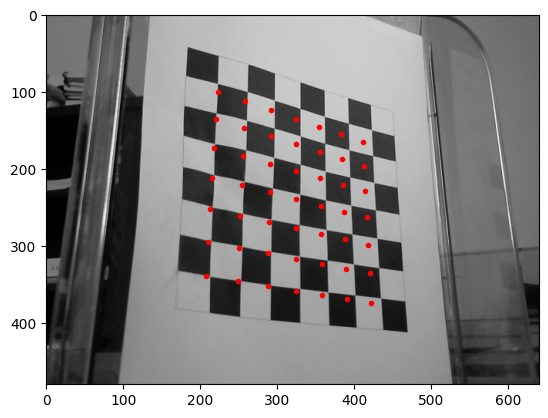

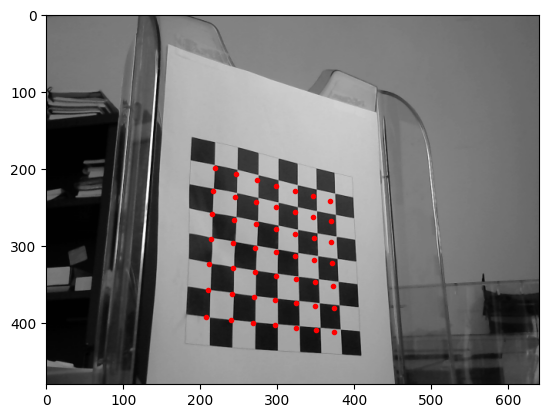

In [40]:
#Création de la matrice de coordonnées spatiales (mm)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2) * c
obj_point = []
obj_point.append(objp)
obj_point.append(objp)

#Initialisaiton de la matrice de coordonnées pixels issue des détections précédemments faite par cv2.findChessboardCorners
corners_px = np.zeros((7*7,2),np.float32)
corners_px2 = np.zeros((7*7,2),np.float32)

#Création de la matrice de coordonnées pixels dans le bon format
index_px = 0
for coord in corners:
    corners_px[index_px] = (coord[0][0], coord[0][1])
    index_px+=1

index_px = 0
for coord in corners2:
    corners_px2[index_px] = (coord[0][0], coord[0][1])
    index_px+=1

img_point = []
img_point.append(corners)
img_point.append(corners2)

#Calibrage de la caméra
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_point, img_point, [img.shape[0], img.shape[1]], None, None)

#Création des matrices de rotation issues du calibrage pour la mire 1
Rphi_1 = [[1, 0, 0],[0, np.cos(rvecs[0][0][0]), -np.sin(rvecs[0][0][0])],[0, np.sin(rvecs[0][0][0]), np.cos(rvecs[0][0][0])]]
Rgamma_1 = [[np.cos(rvecs[0][1][0]), 0, np.sin(rvecs[0][1][0])],[0,1,0],[-np.sin(rvecs[0][1][0]), 0, np.cos(rvecs[0][1][0])]]
Romega_1 = [[np.cos(rvecs[0][2][0]), -np.sin(rvecs[0][2][0]), 0],[np.sin(rvecs[0][2][0]), np.cos(rvecs[0][2][0]),0],[0,0,1]]
R_1 = np.dot(np.dot(Rphi_1, Rgamma_1), Romega_1)

#Création des matrices de rotation issues du calibrage pour la mire 2
Rphi_2 = [[1, 0, 0],[0, np.cos(rvecs[1][0][0]), -np.sin(rvecs[1][0][0])],[0, np.sin(rvecs[1][0][0]), np.cos(rvecs[1][0][0])]]
Rgamma_2 = [[np.cos(rvecs[1][1][0]), 0, np.sin(rvecs[1][1][0])],[0,1,0],[-np.sin(rvecs[1][1][0]), 0, np.cos(rvecs[1][1][0])]]
Romega_2 = [[np.cos(rvecs[1][2][0]), -np.sin(rvecs[1][2][0]), 0],[np.sin(rvecs[1][2][0]), np.cos(rvecs[1][2][0]),0],[0,0,1]]
R_2 = np.dot(np.dot(Rphi_2, Rgamma_2), Romega_2)

#Creation de la matrice augmentée M_int
Mint_cv = np.c_[mtx, [0,0,0]]

#Creation de la matrice augmentée M_ext pour la mire 1
Mext_cv_1 = np.c_[R_1, tvecs[0]]
Mext_cv_1 = np.vstack([Mext_cv_1, [0,0,0,1]])
M_cv_1 = np.dot(Mint_cv, Mext_cv_1)

#Creation de la matrice augmentée M_ext pour la mire 2
Mext_cv_2 = np.c_[R_2, tvecs[1]]
Mext_cv_2 = np.vstack([Mext_cv_2, [0,0,0,1]])
M_cv_2 = np.dot(Mint_cv, Mext_cv_2)

#Projection des points Objets dans le repère Pixels issue du calibrage pour la mire 1
U = []
plt.imshow(img)
for i in range(49):
    x1 = obj_point[0][i][0]
    x2 = obj_point[0][i][1]
    x3 = obj_point[0][i][2]
    
    X = [x1,x2,x3, 1]
    U.append([np.dot(M_cv_1, X)])

#Division des coordonnées u1 et u2 par alpha
Ux = [U[i][0][0]/U[i][0][2] for i in range(len(U))]
Uy = [U[i][0][1]/U[i][0][2] for i in range(len(U))]

#Affichage des points projetés dans le repère Pixels
plt.scatter(Ux,Uy, marker = ".", color = "r")

#Sauvegarde de l'image de la mire 1 issue du calibrage d'opencv
plt.savefig("imcv.png")
plt.show()





#Projection des points Objets dans le repère Pixels issue du calibrage pour la mire 2
U = []
plt.imshow(img2)
for i in range(49):
    x1 = obj_point[1][i][0]
    x2 = obj_point[1][i][1]
    x3 = obj_point[1][i][2]
    
    X = [x1,x2,x3, 1]
    U.append([np.dot(M_cv_2, X)])

#Division des coordonnées u1 et u2 par alpha
Ux = [U[i][0][0]/U[i][0][2] for i in range(len(U))]
Uy = [U[i][0][1]/U[i][0][2] for i in range(len(U))]

#Affichage des points projetés dans le repère Pixels
plt.scatter(Ux,Uy, marker = ".", color = "r")

#Sauvegarde de l'image de la mire 2 issue du calibrage d'opencv
plt.savefig("imcv2.png")
plt.show()
